In [16]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.geometry_torch import to_device, concat_dict_entries, geometry_to_net_input, unpack, GeomData, concat_dicts, subdict
from boundary_solvers.geometry import GPDomain, RoundedMicroGeomV2
from architecture.fno_1d import FNO1d
import matplotlib.pyplot as plt
from hmm.stokes import StokesMicProb
from hmm.stokes_deep import DeepMicroSolver, get_net
from dataclasses import dataclass
import numpy as np
import time
import torch
import torch.nn as nn


# def get_net(settings, device, dtype):
#     bias = settings["bias"] if "bias" in settings else True
#     activation = settings["activation"] if "activation" in settings else F.gelu
#     kernel_size = settings["kernel_size"] if "kernel_size" in settings else 1
#     batch_norm = settings["batch_norm"] if "batch_norm" in settings else False
    
#     net = FNO1d(modes=settings["modes"], 
#                 in_channels=len(settings["input_features"]), 
#                 out_channels=len(settings["output_features"]), 
#                 layer_widths=settings["layer_widths"],
#                 bias = bias,
#                 activation=activation,
#                 kernel_size=kernel_size,
#                 batch_norm=batch_norm,
#                 dtype=dtype)
    
#     net.to(device)
#     if settings["skip"]:
#         class SkipNet(nn.Module):
#             def __init__(self, net):
#                 super(SkipNet, self).__init__()
#                 self.net = net
            
#             def forward(self, x):
#                 return self.net(x) + x[:, -4:, :]
#         net = SkipNet(net)
#     return net

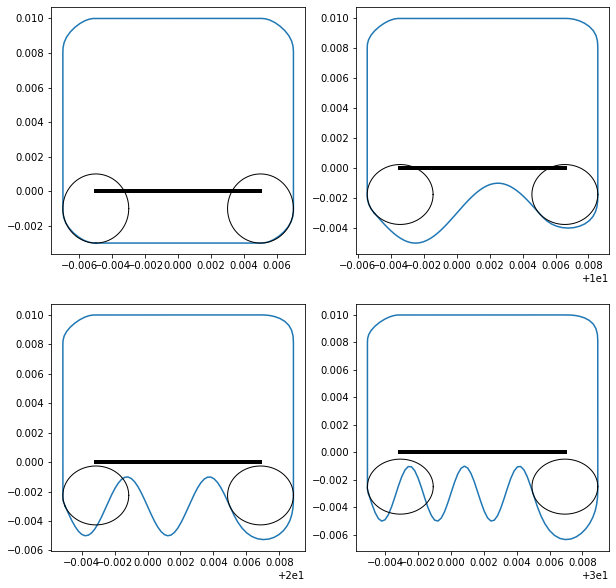

In [17]:
default_parameters = {"kernel": "exp", "shape":.05, "num":20, "scale":.05, "bound":.3, "verbose": False, "width":1, "height":1, "corner_w":0.3, "line_pos":0.1, "n_refine":2, "n_corner_refine":0}
randomisers = {"width": lambda: 0.5 + np.random.rand()*0.5, 
               "scale": lambda: 0.01 + 10 ** (-np.random.rand()-1), 
               "height": lambda: 0.7 + np.random.rand()*0.5, 
               "corner_w": lambda: np.random.rand()*0.2 + 0.1, 
               "line_pos": lambda: np.random.rand()*0.1 + 0.1}
to_randomise = ["height", "corner_w", "line_pos", "scale"]
kwargs = {**default_parameters}

@dataclass
class MicData:
    geom: GPDomain

def get_funcs(k, eps):
    func = lambda t: -0.2*(1.5+np.sin(k*t)) * eps
    dfunc = lambda t: -0.2*k*np.cos(k*t) * eps
    ddfunc = lambda t: 0.2*k**2*np.sin(k*t) * eps
    return func, dfunc, ddfunc
    

geoms = []
plt.figure(figsize=(10,10))
for i in range(4):
    for key in to_randomise:
        kwargs[key] = randomisers[key]()
        
    dom = GPDomain(**kwargs)
    
    eps = 0.01
    func, dfunc, ddfunc = get_funcs(i*4., eps)
    dom = RoundedMicroGeomV2(func, dfunc, ddfunc, width=1. * eps, height=1. * eps, corner_w=.2 * eps, line_pos=0.0*eps, center_x=10*i, n_refine=2)
    geoms.append(dom)
    
    plt.subplot(2,2,i+1)
    dom.plot(ax=plt.gca())
    

    
    

In [18]:
geom_data = [unpack(lambda x: torch.from_numpy(x)[None, :])(geometry_to_net_input(dom, 256, output=True)) for dom in geoms]
data = geom_data[0]
for g in geom_data[1:]:
    data = concat_dicts(data, g, axis=0)
data = GeomData.tfm_inp(data)
data = GeomData.tfm_out(data, data)

In [19]:
device = "cuda:1"
path = f"/home/emastr/phd/data/runs/fnoskip_big_data_49_{40000}.Torch"
net, settings = get_net(path, 256, device, "float")

X = concat_dict_entries(subdict(data, settings["input_features"])).to(device).float()
print(settings["input_features"], X.shape)

solvers = [DeepMicroSolver(MicData(geom), net, settings, None) for geom in geoms]

['c_norm', 'vt', 'vn', 'dvt_norm', 'dvn_norm'] torch.Size([4, 5, 256])


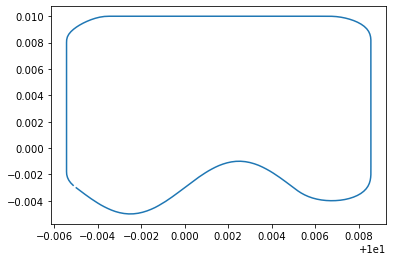

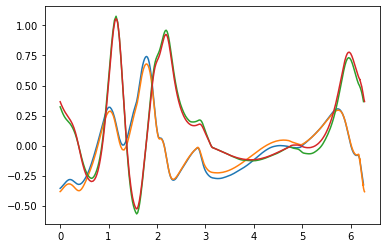

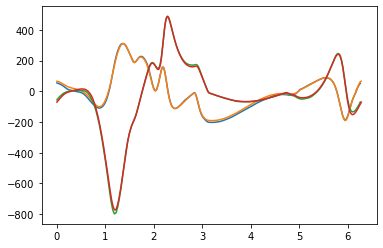

In [20]:
solvers[1].plot()

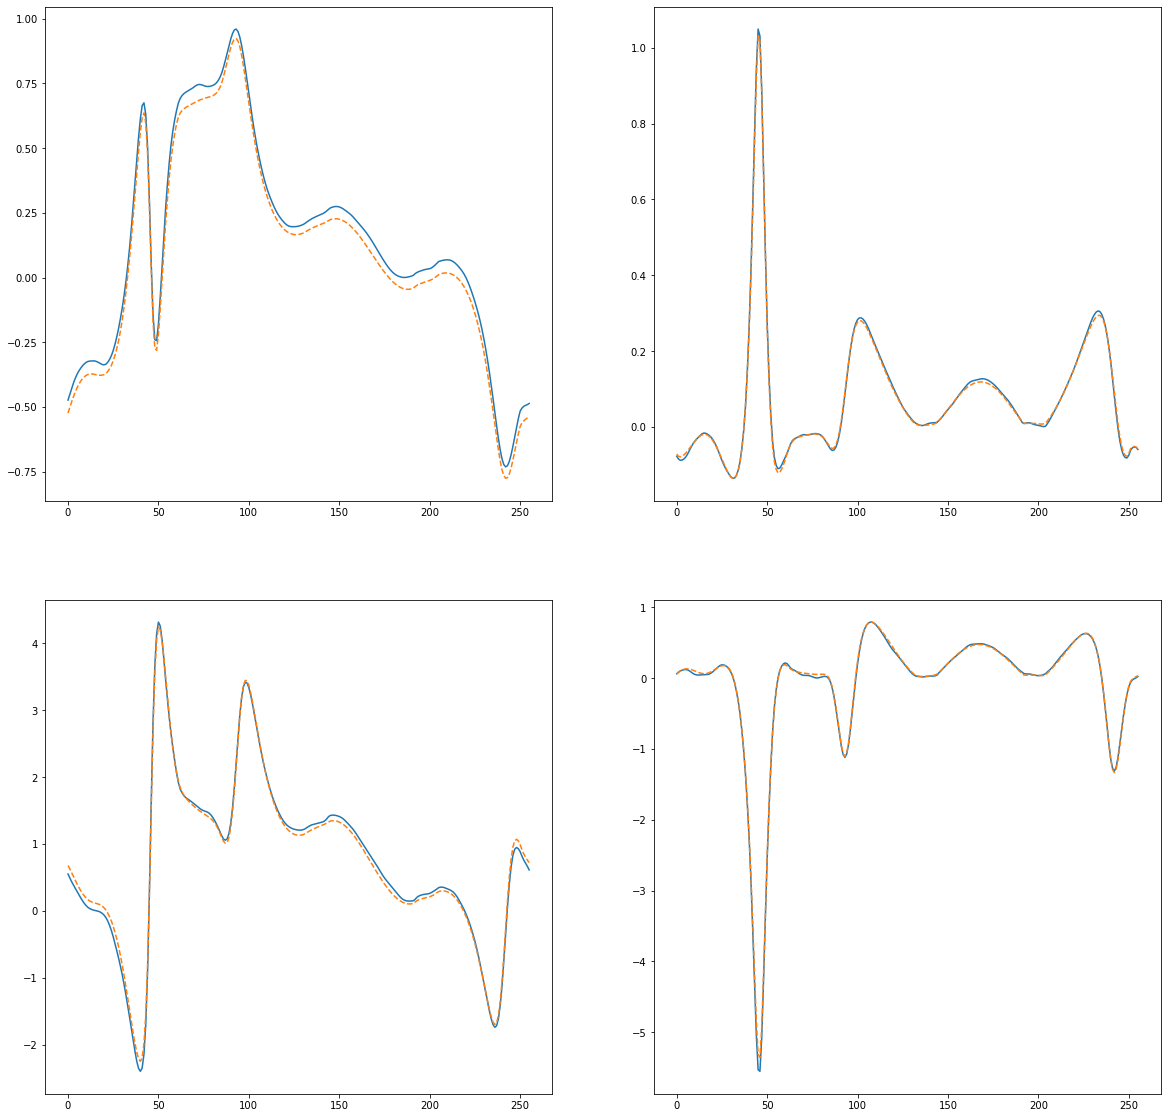

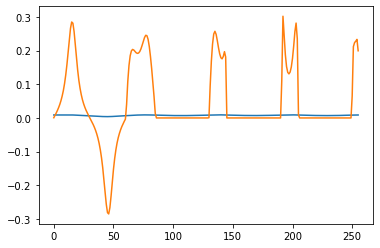

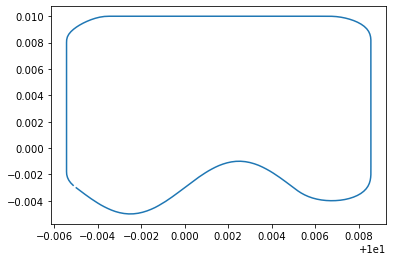

In [21]:
Y = net(X).detach().cpu().numpy()

i = 1

plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.plot(Y[i, 0, :])
plt.plot(data["rt"][i], '--')

plt.subplot(222)
plt.plot(Y[i, 1, :])
plt.plot(data["rn"][i], '--')

plt.subplot(223)
plt.plot(Y[i, 2, :])
plt.plot(data["drt_norm"][i], '--')

plt.subplot(224)
plt.plot(Y[i, 3, :])
plt.plot(data["drn_norm"][i], '--')


plt.figure()
plt.plot(data["dist"][i])
plt.plot(data["c_norm"][i])

plt.figure()
plt.plot(data["x"][i], data["y"][i])
#plt.plot(geoms[0].eval_param(t=data["t"][0].numpy()).real)